In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
# Load and preprocess the IMDB dataset
vocab_size = 10000
max_length = 200
embedding_dim = 128
rnn_units = 128

In [ ]:
# Load the IMDB dataset
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Create reverse word index for decoding reviews
word_index = tf.keras.datasets.imdb.get_word_index()
reverse_word_index = {value + 3: key for (key, value) in word_index.items()}
reverse_word_index[0], reverse_word_index[1], reverse_word_index[2] = "<PAD>", "<START>", "<UNK>"


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Decode a sample review
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i, '?') for i in encoded_review])


In [ ]:
# Show a sample decoded review with its label
print("Sample review:", decode_review(train_data[0]))
print("Sample label:", "Positive" if train_labels[0] == 1 else "Negative")


Sample review: <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be 

In [ ]:
# Pad the sequences to ensure uniform input length
train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=max_length, padding='post')
test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=max_length, padding='post')

In [ ]:

# Define the RNN model
model = tf.keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.SpatialDropout1D(0.2),
    layers.GRU(rnn_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.001)),
    layers.GRU(rnn_units, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')



In [ ]:
# Training the model with callbacks
epochs = 15
batch_size = 64

history = model.fit(
    train_data, train_labels, epochs=epochs, batch_size=batch_size,
    validation_data=(test_data, test_labels),
    callbacks=[early_stopping, model_checkpoint], verbose=1
)

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 478s 1s/step - accuracy: 0.5076 - loss: 231756864.0000 - val_accuracy: 0.5494 - val_loss: 0.7150
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accuracy: 0.5561 - loss: 0.7377 - val_accuracy: 0.5782 - val_loss: 0.7141
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.6231 - loss: 248490672.0000 - val_accuracy: 0.5597 - val_loss: 0.7495
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.6229 - loss: 23.1383 - val_accuracy: 0.5753 - val_loss: 0.7441
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.6378 - loss: 11.0371 - val_accuracy: 0.5751 - val_loss: 0.7596


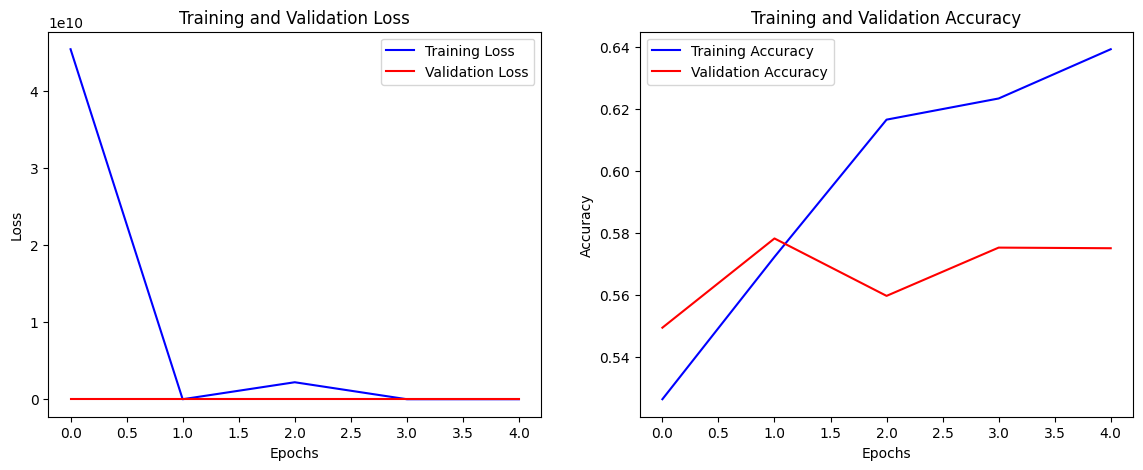

In [ ]:
# Plotting the training and validation loss and accuracy
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(history.history['loss'], label='Training Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy plot
    ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

plot_metrics(history)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=2)
print(f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')

# Load the best saved model
model.load_weights('best_model.keras')


782/782 - 73s - 93ms/step - accuracy: 0.5782 - loss: 0.7141
Test Accuracy: 0.5782, Test Loss: 0.7141


In [ ]:
# Predict on test data and show predictions for a few reviews
predictions = model.predict(test_data[:5])

for i, prediction in enumerate(predictions):
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    print(f"\nReview {i + 1} Prediction: {sentiment} (Confidence: {prediction[0]:.2f})")
    print(f"Actual Label: {'Positive' if test_labels[i] == 1 else 'Negative'}")
    print("Review text:", decode_review(test_data[i]))
    print("------------------------------------------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step

Review 1 Prediction: Positive (Confidence: 0.51)
Actual Label: Negative
Review text: <START> please give this one a miss br br <UNK> <UNK> and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite <UNK> so all you madison fans give this a miss <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

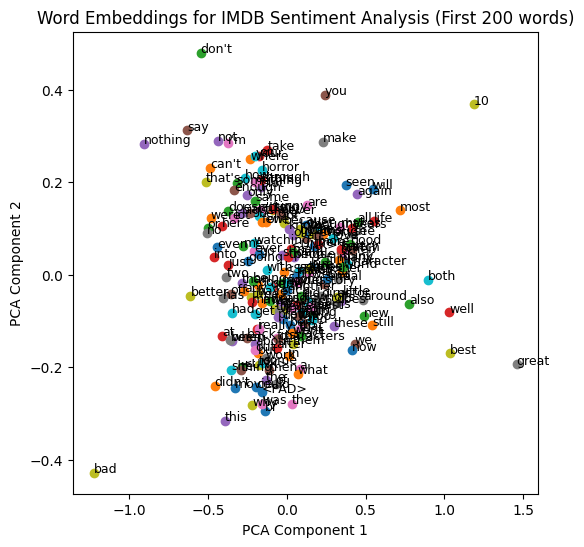

In [ ]:
# Visualizing word embeddings
# Extract embeddings and plot using PCA
embedding_layer = model.layers[0]
embeddings = embedding_layer.get_weights()[0]

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings[:200])  # Take first 200 words for visualization

plt.figure(figsize=(6, 6))
for i in range(200):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.annotate(reverse_word_index.get(i, "<UNK>"), (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9)
plt.title("Word Embeddings for IMDB Sentiment Analysis (First 200 words)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [ ]:
# Additional predictions on random test reviews with interpretation
print("\nAdditional Model Predictions on Random Test Samples:")
num_samples = 5
random_indices = np.random.choice(len(test_data), num_samples, replace=False)
random_reviews = test_data[random_indices]
random_labels = test_labels[random_indices]

for i, review in enumerate(random_reviews):
    prediction = model.predict(np.array([review]))[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    print(f"\nRandom Review {i + 1} Prediction: {sentiment} (Confidence: {prediction:.2f})")
    print(f"Actual Label: {'Positive' if random_labels[i] == 1 else 'Negative'}")
    print("Review text:", decode_review(review))
    print("------------------------------------------------")

# Analysis of predicted sentiment distribution
positive_count = sum([1 for pred in predictions if pred > 0.5])
negative_count = len(predictions) - positive_count

print(f"\nDistribution of Sentiment Predictions (First 5 samples):")
print(f"Positive: {positive_count}, Negative: {negative_count}")
print("------------------------------------------------")


Additional Model Predictions on Random Test Samples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step

Random Review 1 Prediction: Negative (Confidence: 0.49)
Actual Label: Positive
Review text: music were all good it's just that after you see a bunch of people doing things you can't truly relate to the movie ends it is educational in the way that it shows the horrors of war as seen from home and the way feelings don't need to make any sense at all and still be strong but that's about it br br the plot covers a period of a few years in which the poet dylan thomas is taken under the roof of a former ex girlfriend he is married brings his wife and later the kid while the ex knightley marries some other guy but the tension is there dylan is a self obsessed jerk and the new husband comes back home from the war with a slight case of <UNK> add in some pretty <UNK> characters and you have your hands full br br bottom line you have to be in the mood to like this film the hard part is defining this mood